# はじめに
機械学習モデルの出力から、どの程度プライバシーが漏洩する危険性があるかを評価します。  


### 概要
- メンバーシップ推定攻撃で、モデルが教師データをどの程度記憶しているか評価する。
- 予測の確信度が閾値より大きい場合に、教師データに含まれていたと判定するメンバーシップ推定攻撃の成功率を確認する。
- 閾値はshadow modelを用いて最適化する。


### 参考資料
- Building an Image Classifier with Differential Privacy (Opacus Tutorials)  
https://opacus.ai/tutorials/building_image_classifier
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

# メンバーシップ推定攻撃
メンバーシップ推定攻撃は、教師データがどの程度モデルに記憶されているかに基づいて、プライバシー侵害の危険性を評価する際に用いられます。

### 基本的な考え方
下記の図のように、あるデータ（以降、ターゲット）を含まないデータセットと、ターゲットをデータを含むデータセットで学習したモデル$F_{out}$と$F_{in}$を考えます。  
例えば、それぞれのモデルでターゲットを予測した結果が、$F_{out}$では不正解だが、$F_{in}$では正解だった場合、モデルがターゲットを記憶して正解できたと捉えることができます。  

メンバーシップ推定攻撃に基づくプライバシー評価では、モデルがターゲットを記憶した場合、ターゲットがモデルに含まれていたかどうかでモデルの出力が大きく変化する点に着目しています。  
モデルがターゲットを記憶していた場合、ターゲットが教師データに含まれていたかどうかの判定は、容易に行うことができます。  
この観察に基づいて、メンバーシップ推定攻撃では、各データが教師データに含まれていたかどうかを予測しますが、その成功率がプライバシー保護の指標として用いられています。

まとめると、  
　　教師データに含まれていたかを判定可能（メンバーシップ推定攻撃が成功） ⇒ モデルが教師データを記憶 ⇒ 教師データのプライバシーが保護されていない  
という考えに基づいてプライバシー保護の評価を行います。





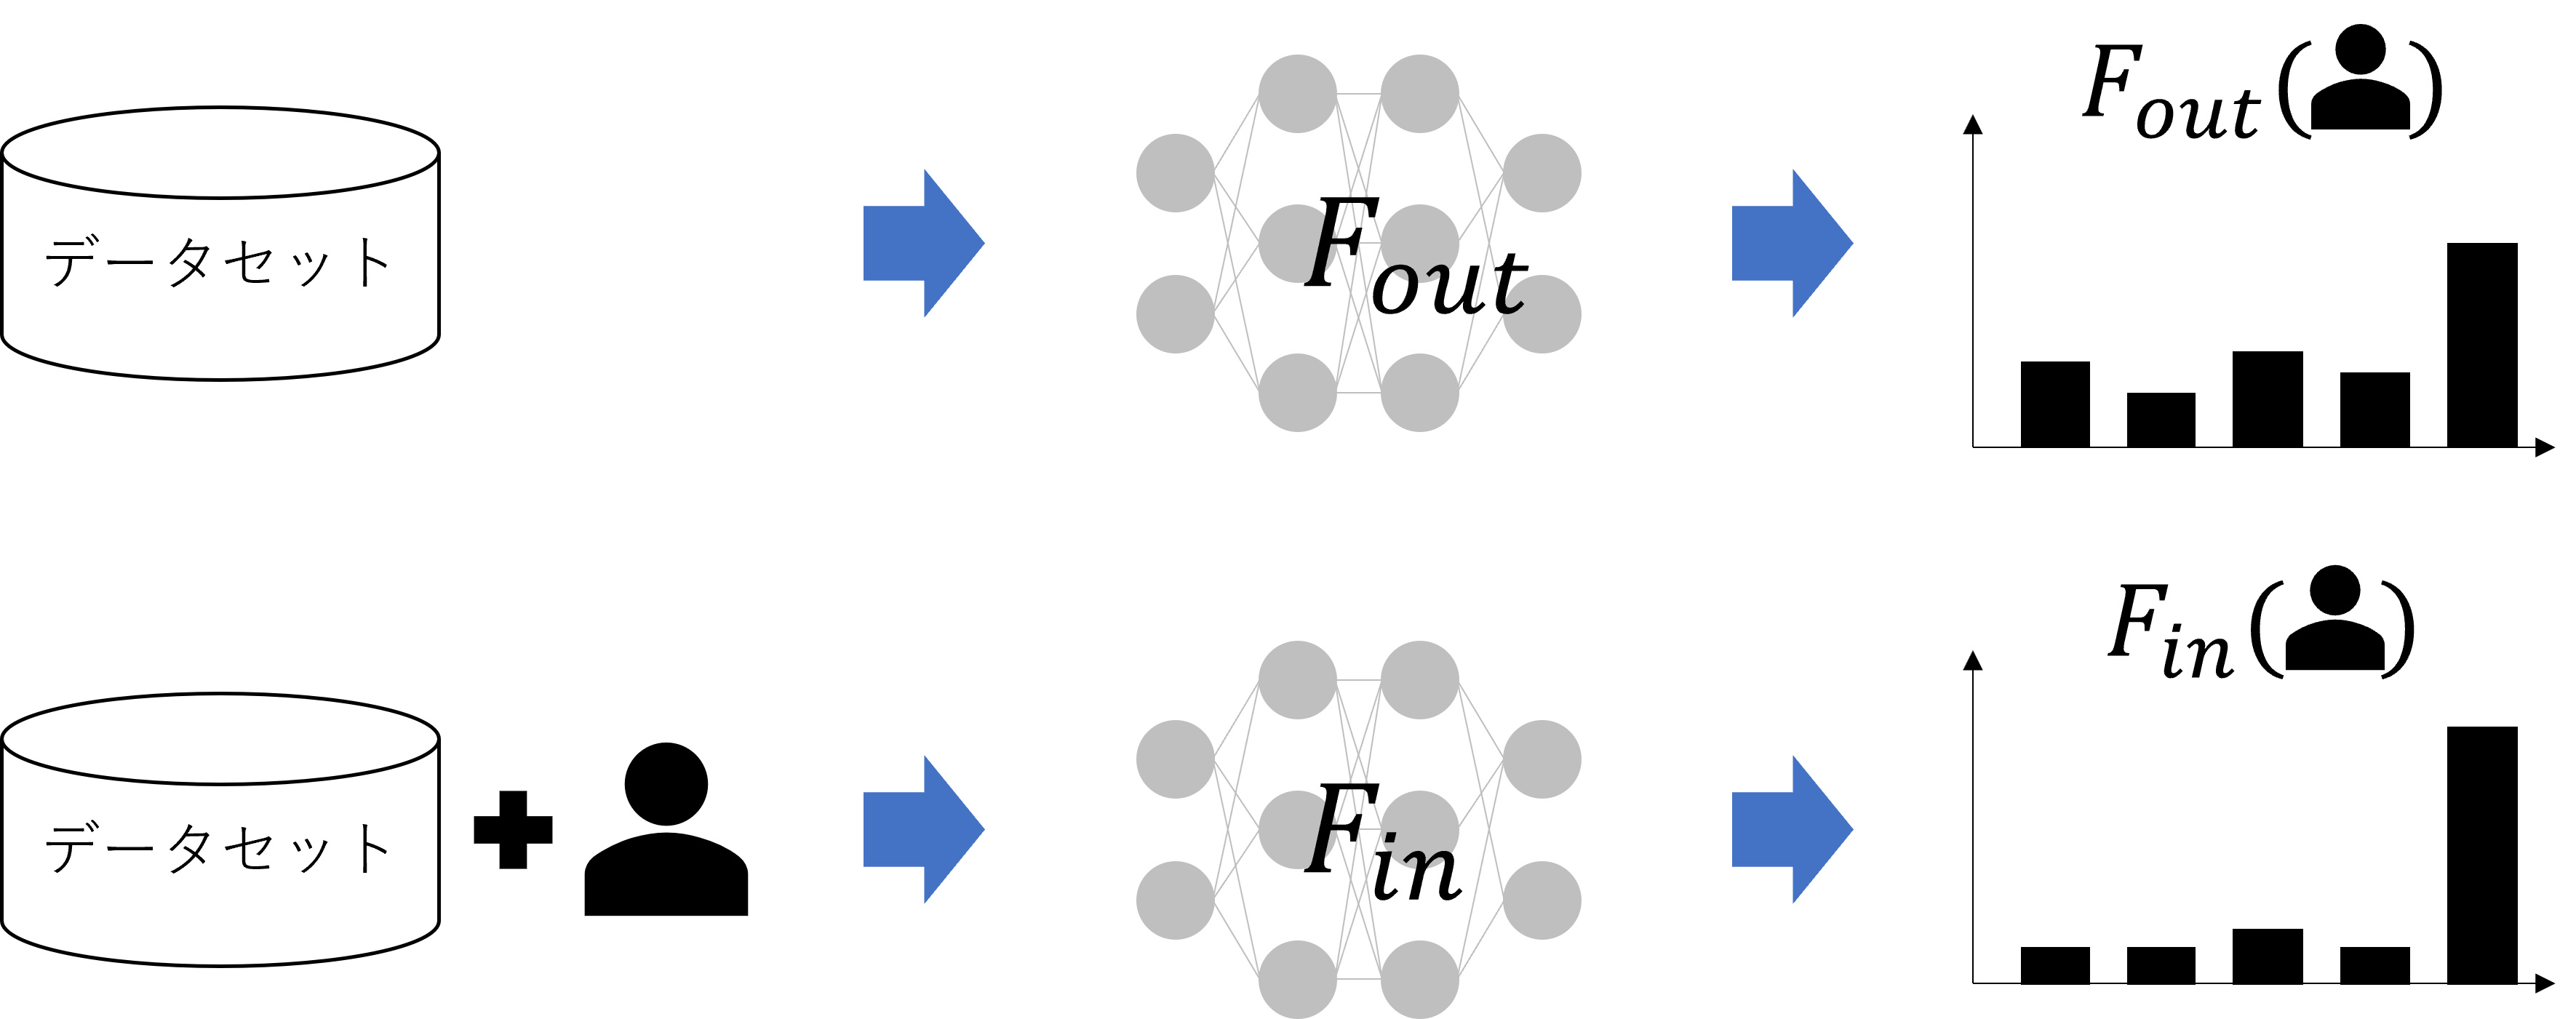


### 評価の手順
1. 閾値の決定  
1-1. データセットを均等に分割し、一方を教師データに使用し（Member）
、もう一方は使用せず（Non-member）shadow model$F_s$の学習を複数回行います。   
1-2. これらのshadow modelに対して、正解クラスの確信度が、閾値より大きい場合に使われていた（Member）、閾値以下の場合に使われていなかった（Non-member）と予測するメンバーシップ推定攻撃攻撃を行った際の最適な閾値を選択します。  
2. メンバーシップ推定攻撃  
2-1. データセットを均等に分割し、一方を教師データに使用し（Member）
、もう一方は使用せず（Non-member）モデル$F$の学習を行います。分割する際のシードはshadow modelの際とは異なるものを使用します。  
2-2. 正解クラスの確信度が、選択された閾値より大きい場合に使われていた（Member）、0.5以下の場合に使われていなかった（Non-member）、と予測するメンバーシップ推定攻撃を実施します。



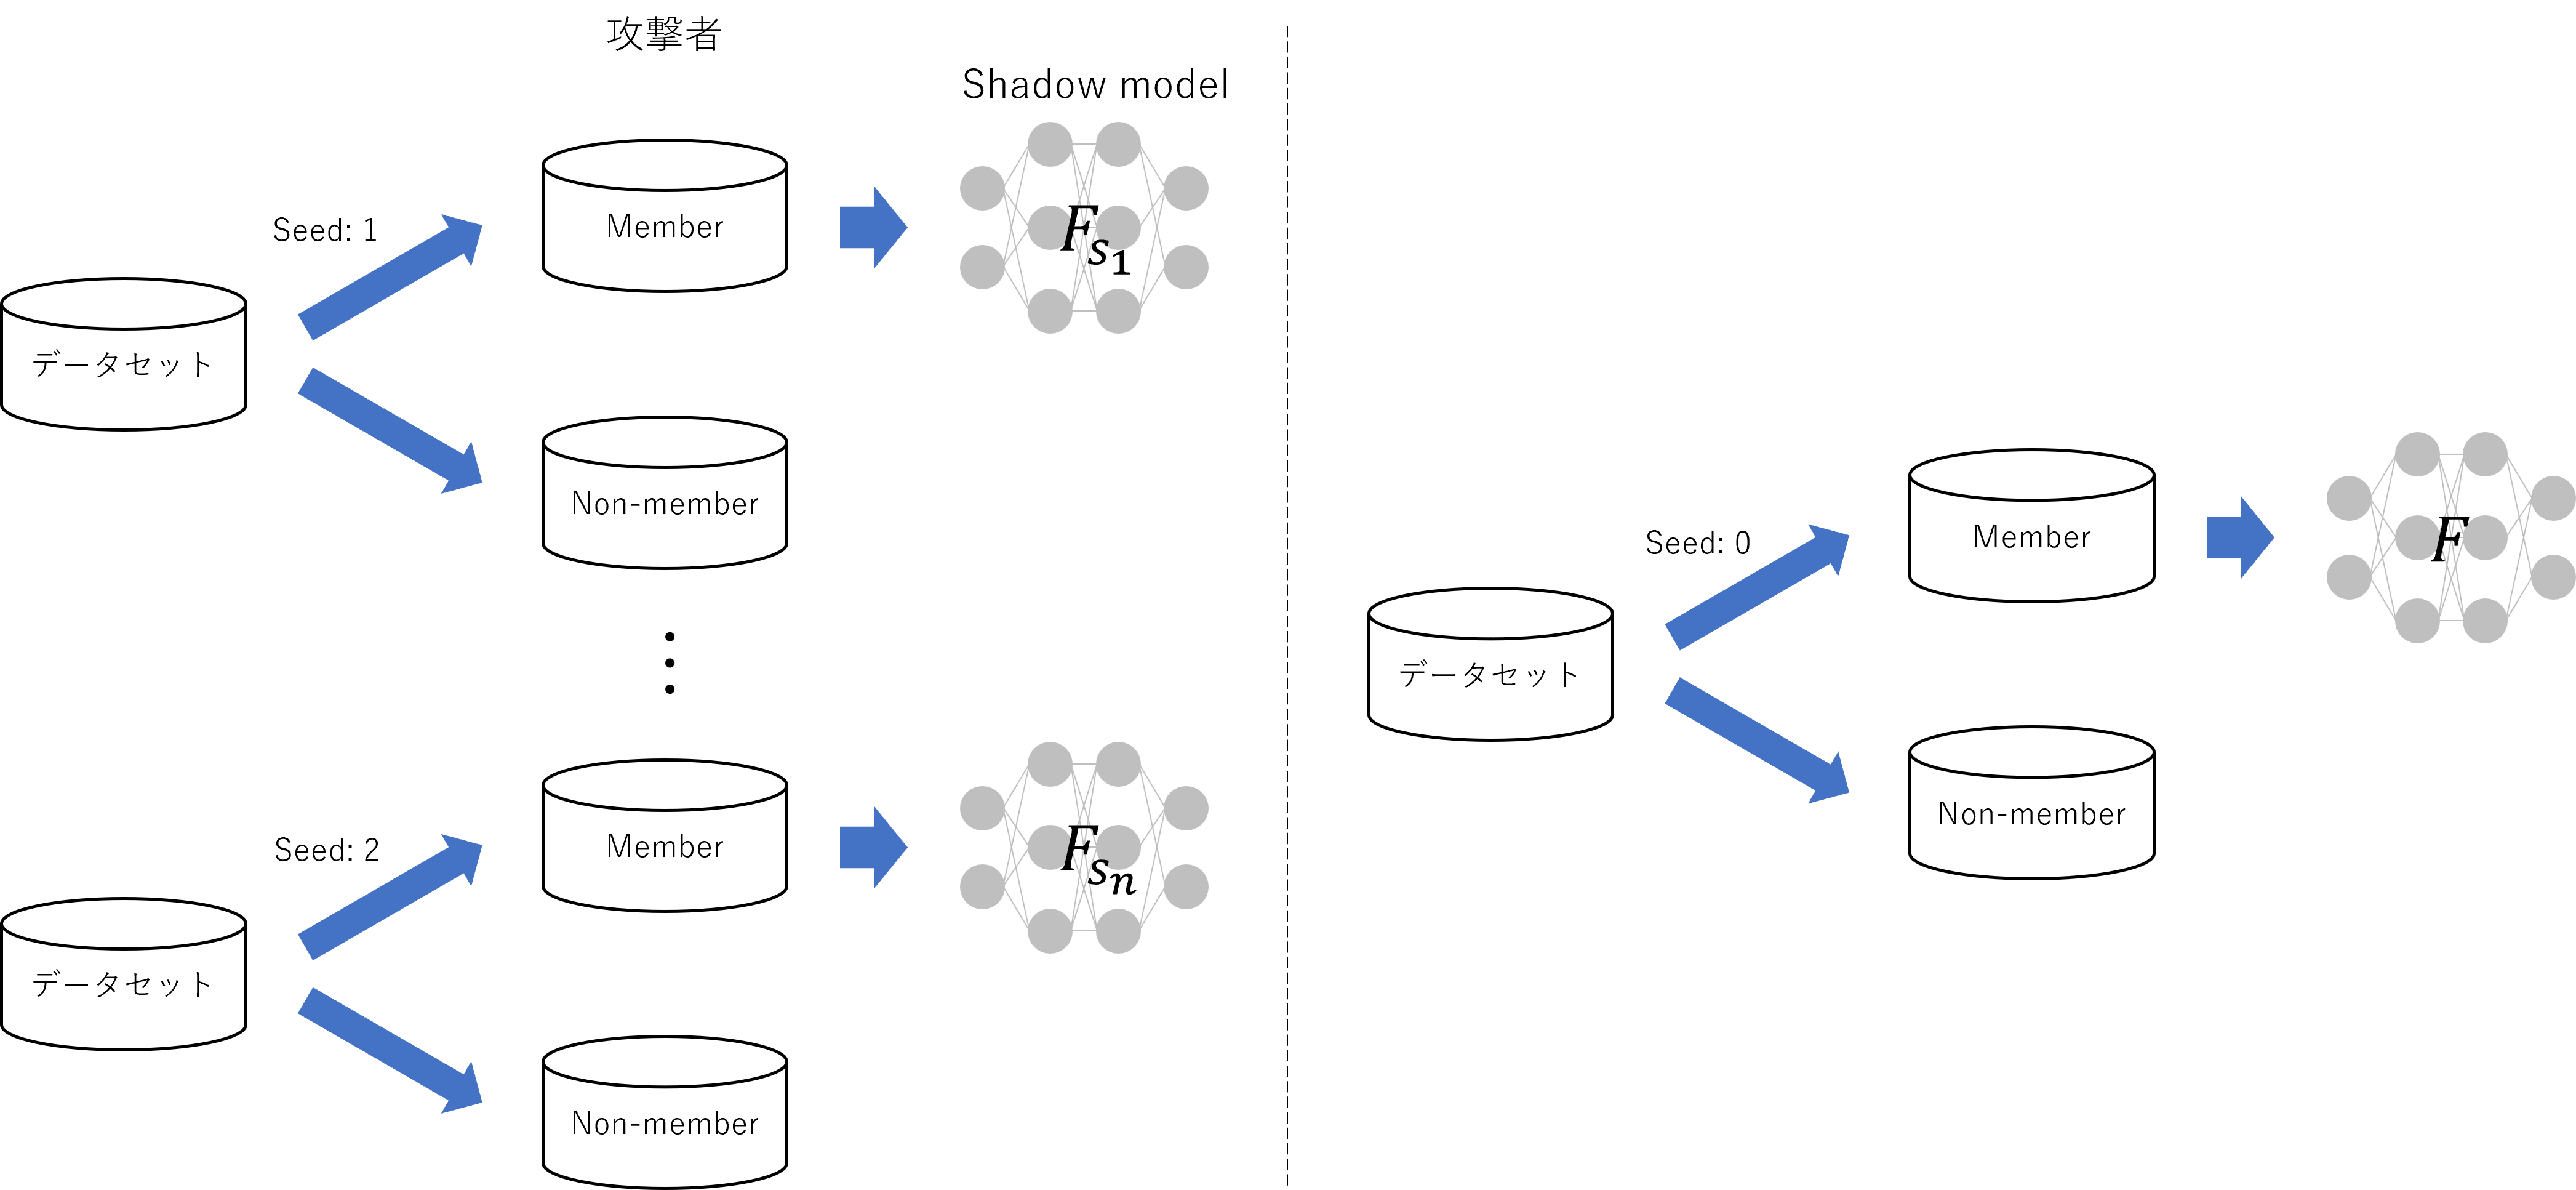

# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import os
import pickle

!pip install 'opacus>=1.0'
import opacus
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager

import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
Opacusは1.0.0で書き方が大きく変わっているので注意してください。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [ ]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
print('Opacus:', opacus.__version__)
!nvidia-smi

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
PyTorch: 2.0.0+cu118
Torchvision: 0.15.1+cu118
Opacus: 1.4.0
Sun Apr 23 06:43:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------

### 3. データセットの用意  

カラー画像データセットの[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)を、torchvisionを用いて取得します。  
全てのデータに、下記の操作を適用します。
- ToTensor：データをTensor型に変換
- Normalize：各チャネルの平均が0、標準偏差が1となるように標準化

差分プライバシーを適用しない場合のみ、data augmentationを適用するために、data augmentation用の関数も用意しておきます。


In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)

# for data augmentation
trans = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
    ]
)


100%|██████████| 170498071/170498071 [00:02<00:00, 79493968.06it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### 4. 学習の関数化

今回は、異なる条件で複数回学習を実行するため、学習部分を関数として定義します。
各エポックのテスト精度と消費した$\epsilon$を出力します。  
教師データの分割では、再現可能なようにシードを固定しています。
学習したモデルは今後再利用可能なように、保存しておきます。  
学習データを半分にしているので、エポック数は30としました。

In [ ]:
def training(batch_size = 512, sigma=1.0, c=1.0, idx=0, dp_flag=0, dir='/content/drive/MyDrive/model'):    
    if dp_flag == 1:
        if os.path.exists(f"{dir}/model_dp_{idx}.pt"):
            print(f"model_dp_{idx}.pt exist")
            return
    else:
        if os.path.exists(f"{dir}/model_{idx}.pt"):
            print(f"model_{idx}.pt exist")
            return

    #split training data
    train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

    # make dataloader
    train_dataloader = DataLoader(train_in, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

    # make model
    model = torchvision.models.resnet18()
    # fix model for DP-SGD
    if dp_flag == 1:
        model = ModuleValidator.fix(model)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = model.to(device)

    # make optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # DP-SGD settig
    if dp_flag == 1:
        privacy_engine = opacus.PrivacyEngine()
        model, optimizer, train_dataloader = privacy_engine.make_private(
            module=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            noise_multiplier=sigma,
            max_grad_norm=c,
        )

    # training 
    pbar = tqdm(range(30), desc=f"[idx: {idx}]")
    for epoch in pbar:
            
        if dp_flag == 1:
            with BatchMemoryManager(
                data_loader=train_dataloader, 
                max_physical_batch_size=64, 
                optimizer=optimizer
            ) as memory_safe_data_loader:
                model.train()
                for (X, y) in memory_safe_data_loader:
                    X, y = X.to(device), y.to(device)

                    # optimization step
                    optimizer.zero_grad()
                    pred = model(X)
                    loss = criterion(pred, y)
                    loss.backward()
                    optimizer.step()
        else:
            model.train()
            for (X, y) in train_dataloader:
                X, y = X.to(device), y.to(device)

                # data augmentation for non-DP
                X = trans(X)

                # optimization step
                optimizer.zero_grad()
                pred = model(X)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()

    # calculate epsilon
    if dp_flag == 1:
        epsilon = privacy_engine.get_epsilon(1e-5)
    else:
        epsilon = -1
    
    # test
    model.eval()
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            loss = criterion(pred, y)

            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_acc = metrics.accuracy_score(y_list, pred_list)
    print(f'epsilon: {epsilon}, test accuracy: {test_acc}')

    #save model
    if dp_flag == 1:
        torch.save(model._module.state_dict(), f"{dir}/model_dp_{idx}.pt")
    else:
        torch.save(model.state_dict(), f"{dir}/model_{idx}.pt")

    

### 5. 学習
Google driveにモデルを保存するために、マウントします。
その後、DP-SGDを適用しない場合と、DP-SGDを適用した場合それぞれでモデルの学習を行います。  
今回は、閾値選択に4つのモデルを使用するため、合計で5つのモデルの学習を行います。


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for idx in range(5):
    training(batch_size=128, idx=idx)
    training(dp_flag=1, idx=idx)

model_0.pt exist
model_dp_0.pt exist
model_1.pt exist
model_dp_1.pt exist
model_2.pt exist
model_dp_2.pt exist
model_3.pt exist
model_dp_3.pt exist
model_4.pt exist
model_dp_4.pt exist


### 6. メンバーシップ推定攻撃

#### 最適な閾値の計算
インデックスが1-4のモデルを使用して、最適な閾値を選択します。




In [ ]:
def calc_threshold(sigma=1.0, c=1.0, target_idx=0, n_models=5, dp_flag=0, dir='/content/drive/MyDrive/'):
    inference = []
    ans = []

    for idx in range(n_models):
        if idx == target_idx:
            continue

        #split training data
        train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

        # make dataloader
        in_loader = DataLoader(train_in, batch_size=1024, shuffle=False)
        out_loader = DataLoader(train_out, batch_size=1024, shuffle=False)

        # make model
        model = torchvision.models.resnet18()
        if dp_flag == 1:
            model = ModuleValidator.fix(model)

        device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        model = model.to(device)

        if dp_flag == 1:
            fname = f"{dir}/model/model_dp_{idx}.pt"
        else:
            fname = f"{dir}/model/model_{idx}.pt"
        
        model.load_state_dict(torch.load(fname))
        print(f'{fname} loaded')

        # MIA
        # member
        with torch.no_grad():
            for X, y in in_loader:
                X, y = X.to(device), y.to(device)
                
                pred =  torch.nn.Softmax()(model(X))
                for i in range(pred.shape[0]):
                    inference.append(pred[i,y[i]].item())
                    ans.append(1)
        
        #non-member
        with torch.no_grad():
            for X, y in out_loader:
                X, y = X.to(device), y.to(device)

                pred = torch.nn.Softmax()(model(X))
                for i in range(pred.shape[0]):
                    inference.append(pred[i,y[i]].item())
                    ans.append(0)

    fpr, tpr, thresholds = metrics.roc_curve(ans, inference)
    TP = tpr*np.sum(ans)
    TN = (1-fpr)*np.sum(1-np.array(ans))
    accuracy = (TP+TN) / float(len(ans))
    plt.plot(thresholds, accuracy)
    plt.ylabel('MIA accuracy')
    plt.xlabel('Threshold')
    plt.xlim(0,1)
    plt.show()

    i = np.argmax(accuracy)

    print(f'Best MIA accuracy: {accuracy[i]}, threshold: {thresholds[i]}')
    
    if dp_flag == 1:
        f = open(dir + f'/data/threshold_dp_{target_idx}.pkl', 'wb')
    else:
        f = open(dir + f'/data/threshold_{target_idx}.pkl', 'wb')
    pickle.dump((thresholds[i], accuracy[i]), f)


/content/drive/MyDrive//model/model_1.pt loaded
/content/drive/MyDrive//model/model_2.pt loaded
/content/drive/MyDrive//model/model_3.pt loaded
/content/drive/MyDrive//model/model_4.pt loaded


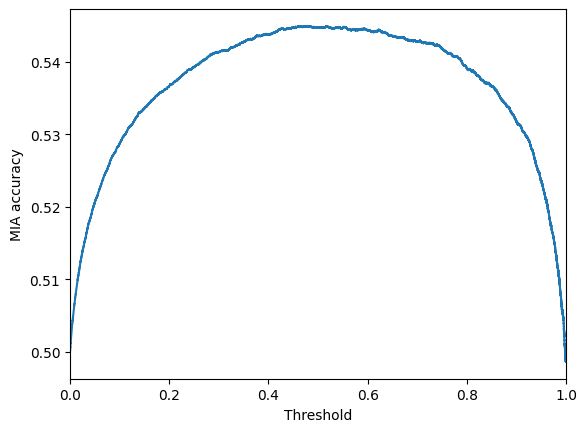

Best MIA accuracy: 0.54493, threshold: 0.4795417785644531
/content/drive/MyDrive//model/model_dp_1.pt loaded
/content/drive/MyDrive//model/model_dp_2.pt loaded
/content/drive/MyDrive//model/model_dp_3.pt loaded
/content/drive/MyDrive//model/model_dp_4.pt loaded


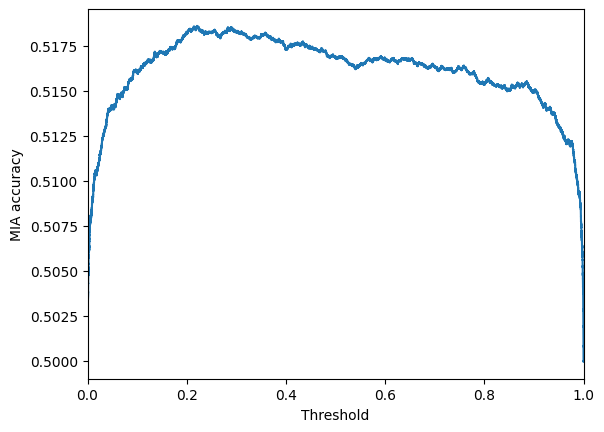

Best MIA accuracy: 0.51859, threshold: 0.22114455699920654


In [ ]:
calc_threshold(target_idx=0)
calc_threshold(dp_flag=1, target_idx=0)

#### メンバーシップ推定攻撃の実行
正解クラスの確信度が閾値より大きい場合にMemberと予測するメンバーシップ推定攻撃を行います。

In [ ]:
def MIA(sigma=1.0, c=1.0, idx=0, dp_flag=0, dir='/content/drive/MyDrive/'):
    if dp_flag == 1:
        f = open(dir + f'/data/threshold_dp_{idx}.pkl', 'rb')
    else:
        f = open(dir + f'/data/threshold_{idx}.pkl', 'rb')
    threshold, accuracy = pickle.load(f)
    print('Threshold', threshold)
    #split training data
    train_in, train_out = torch.utils.data.random_split(dataset=training_data, lengths=[25000, 25000], generator=torch.Generator().manual_seed(idx))

    # make dataloader
    in_loader = DataLoader(train_in, batch_size=1024, shuffle=False)
    out_loader = DataLoader(train_out, batch_size=1024, shuffle=False)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)


    # make model
    model = torchvision.models.resnet18()
    if dp_flag == 1:
        model = ModuleValidator.fix(model)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = model.to(device)


    if dp_flag == 1:
        fname = f"{dir}/model/model_dp_{idx}.pt"
    else:
        fname = f"{dir}/model/model_{idx}.pt"
    
    model.load_state_dict(torch.load(fname))
    print(f'{fname} loaded')

    # test
    model.eval()
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)

            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_acc = metrics.accuracy_score(y_list, pred_list)
    print(f'test accuracy: {test_acc}')

    # MIA
    inference = []
    ans = []
    # member
    with torch.no_grad():
        for X, y in in_loader:
            X, y = X.to(device), y.to(device)
            
            pred =  torch.nn.Softmax()(model(X))
            for i in range(pred.shape[0]):
                if pred[i,y[i]] > threshold:
                    inference.append(1)
                else:
                    inference.append(0)
                ans.append(1)
    
    #non-member
    with torch.no_grad():
        for X, y in out_loader:
            X, y = X.to(device), y.to(device)

            pred = torch.nn.Softmax()(model(X))
            for i in range(pred.shape[0]):
                if pred[i,y[i]] > threshold:
                    inference.append(1)
                else:
                    inference.append(0)
                ans.append(0)

    
    mia_acc = metrics.accuracy_score(ans, inference)
    print(f'MIA accuracy: {mia_acc}')

    cm = metrics.confusion_matrix(ans, inference)
    print(cm)
    print()

In [ ]:
MIA()
MIA(dp_flag=1)

Threshold 0.4795417785644531
/content/drive/MyDrive//model/model_0.pt loaded
test accuracy: 0.7811
MIA accuracy: 0.5442
[[ 6106 18894]
 [ 3896 21104]]

Threshold 0.22114455699920654
/content/drive/MyDrive//model/model_dp_0.pt loaded
test accuracy: 0.5031
MIA accuracy: 0.51738
[[10318 14682]
 [ 9449 15551]]



# おわりに


### 今回の結果
Memberかを判定する閾値を最適化した場合の、メンバーシップ推定攻撃を確認しました。  
しかし、最適化しても攻撃成功率はあまり変わりませんでした。


### 次にやること
より高度なメンバーシップ推定攻撃として、機械学習モデルを用いてMemberかどうかを判定する手法を検証したいと思います。



